---
<center>
    <font size='7'>
        <b>Fréquence de Mise à Jour</b>
    </font>
</center>
 <center>
    <font size='7'>
        <br>Partie 3    
    </font>  
</center>

---

# <font size='6'>Préparation de l'étude</font>

In [1]:
# Inline function to format code to PEP8.
%load_ext lab_black

In [2]:
# Importing necessary librairies.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    calinski_harabasz_score,
)
from scipy.cluster.hierarchy import dendrogram, linkage

# Import du dataset
Le dataset importer est celui créé par combinaison de plusieurs datasets dans le premier notebook.

In [3]:
# Path to save images.
path = "Images/Part03/"

# Importing the dataset combined in part 1.
df = (
    pd.read_csv("dataset_part3.csv", index_col=0, parse_dates=[7, 8, 9, 10, 11])
    .dropna(axis="index", subset=["order_purchase_timestamp"])
    .sort_values(by="order_purchase_timestamp")
    .reset_index(drop=True)
)

print(f"Shape of df : {df.shape}")
df.head(5)

C:\Users\daris\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Shape of df : (99441, 40)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,a3e5a7458a61e94c06131898e1b75449,331261d676590bf08bc94e7337c1de6f,23860,mangaratiba,RJ,44879a8f19c5e8a5e9278477b29a29ea,delivered,2016-09-04 21:15:19,2016-10-07 13:18:03,2016-10-18 13:14:51,...,f5becf505f78437b97c853619eb38c00,5.0,ok,ótimo\r\n,2018-08-31 00:00:00,2018-09-01 01:54:49,1.0,boleto,1.0,38.23
1,82a238f8e3cd8ba8688cd74ada659cf1,96f44809ca0fe2591d2f0564d893be44,4278,sao paulo,SP,accd8ec914c1ab328cfbafe6a5339c85,delivered,2016-09-05 00:15:34,2016-10-07 13:17:15,NaT,...,7f1b8626e98fe63dcf3ee4de948da23f,4.0,NaN,"A entrega foi super rápida, mas a qualidade do...",2018-01-30 00:00:00,2018-02-06 22:25:10,1.0,credit_card,1.0,1.77
2,09f166677f364961abf0cfe78df50b03,f84e31805a5c477596610d415106bf2a,97650,itaqui,RS,1cb61aaa63135f552055cf1932adf3be,delivered,2016-09-13 15:24:19,2016-10-07 13:16:46,NaT,...,4a2d8665eeb1bc9e6a2630521500baac,4.0,NaN,NaN,2018-05-06 00:00:00,2018-05-08 01:56:41,1.0,credit_card,4.0,293.66
3,2fc226fece39c0126543c387768ad5ac,9a8809085c8feb9360f282fba0a6d87e,78307,campos de julio,MT,04f7a2c35c535b543c6042ee73b125f0,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,...,4c0476b01dc39292ea2e61a729f8f91e,5.0,NaN,Bom,2018-03-24 00:00:00,2018-03-27 03:12:56,1.0,boleto,1.0,142.21
4,003bc8d06ebed9d146eb9f100d0a89ae,b53bb01fd133da16d7c7d9b602a3aac7,60175,fortaleza,CE,92b678b4a340519864bc48f15ec27285,delivered,2016-10-02 22:07:52,2016-10-06 15:50:56,NaT,...,c2c57c4d9905458ef927a03a36733a17,5.0,NaN,Mercadoria chegou em ótimo estado e da forma q...,2018-04-06 00:00:00,2018-04-07 17:36:39,1.0,credit_card,1.0,600.04


# Etude des clients au cours du temps
Nous voulons regarder ici le changement de clients dans le cluster des meilleurs clients au cours du temps. Cela nous permettra d'établir le temps nécessaire pour effectuer des mise-à-jours de la segmentation de clients.

Pour ce faire, nous compterons le nombre de clients présents dans ce cluster pour toute la période disponible. Ensuite nous remonterons le temps avec un pas de $3$ mois, et nous compterons le nombre de clients qui étaient déjà présents. Cela nous permettra de voir le taux de changement du cluster avec le temps.

Nous créons une classe pour effectuer l'étude en remontant le temps.

In [4]:
class RFM_Clustering:
    """
    Building the RFM table for this period of time.
    """

    def __init__(self, df, ndays):
        self.df = df
        self.ndays = ndays

    def RFM(self):

        # Creation of a filter according to time period.
        df_filtered = self.df.loc[
            self.df.order_purchase_timestamp
            <= (
                self.df.order_purchase_timestamp.min()
                + datetime.timedelta(days=self.ndays)
            ),
            :,
        ]
        self.df_filtered = df_filtered

        # Frequency:
        rfm = (
            pd.DataFrame(df_filtered.loc[:, "customer_unique_id"].value_counts())
            .reset_index()
            .rename(
                columns={
                    "index": "customer_unique_id",
                    "customer_unique_id": "Frequency",
                }
            )
        )

        # Getting rid of customers who bought only once.
        rfm = rfm.loc[rfm.Frequency > 1, :]
        # Removing NaN.
        rfm = rfm.dropna().reset_index(drop=True)

        # Adding expenses.
        rfm = pd.merge(
            rfm,
            df.groupby(by="customer_unique_id")["price"].sum(),
            how="left",
            on="customer_unique_id",
        ).rename(columns={"price": "Monetary"})

        # Function to calculate recency for each customer.
        def Customer_Recency(customer):
            """
            This function takes as argument the customer, and calculate the number of days between the two last purchases of that customer.
            [Argument] :
                - customer : the customer for whom we want to calculate the recency in days.
            """

            customer_data = (
                df_filtered.loc[df_filtered.loc[:, "customer_unique_id"] == customer, :]
                .sort_values(by="order_purchase_timestamp", ascending=False)
                .reset_index()
            )
            if len(customer_data) > 1:
                return (
                    customer_data.loc[0, "order_purchase_timestamp"]
                    - customer_data.loc[1, "order_purchase_timestamp"]
                )

        def Recency(x):
            """This function gives a score according to the recency of the input date.
            [Argument]:
                - x : input date.
            """
            if x >= 0.8 * rfm.Recency.max():
                return 1
            elif x >= 0.6 * rfm.Recency.max() and x < 0.8 * rfm.Recency.max():
                return 2
            elif x >= 0.4 * rfm.Recency.max() and x < 0.6 * rfm.Recency.max():
                return 3
            elif x >= 0.2 * rfm.Recency.max() and x < 0.4 * rfm.Recency.max():
                return 4
            elif x < 0.2 * rfm.Recency.max():
                return 5

        # Function to attribute Frequency score to each customer
        def Frequency(x):
            """This function gives a score according to the frequency of each customer.
            [Argument]:
                - x : input frequency.
            """
            if x >= 0.8 * rfm.Frequency.max():
                return 5
            elif x >= 0.6 * rfm.Frequency.max() and x < 0.8 * rfm.Frequency.max():
                return 4
            elif x >= 0.4 * rfm.Frequency.max() and x < 0.6 * rfm.Frequency.max():
                return 3
            elif x >= 0.2 * rfm.Frequency.max() and x < 0.4 * rfm.Frequency.max():
                return 2
            elif x < 0.2 * rfm.Frequency.max():
                return 1

        # Function to attribute Monetary score to each customer
        def Monetary(x):
            """This function gives a score according to the expenses of each customer.
            [Argument]:
                - x : input total expense.
            """
            if x >= 0.9 * rfm.Monetary.max():
                return 10
            elif x >= 0.8 * rfm.Monetary.max() and x < 0.9 * rfm.Monetary.max():
                return 9
            elif x >= 0.7 * rfm.Monetary.max() and x < 0.8 * rfm.Monetary.max():
                return 8
            elif x >= 0.6 * rfm.Monetary.max() and x < 0.7 * rfm.Monetary.max():
                return 7
            if x >= 0.5 * rfm.Monetary.max() and x < 0.6 * rfm.Monetary.max():
                return 6
            elif x >= 0.4 * rfm.Monetary.max() and x < 0.5 * rfm.Monetary.max():
                return 5
            elif x >= 0.3 * rfm.Monetary.max() and x < 0.4 * rfm.Monetary.max():
                return 4
            elif x >= 0.2 * rfm.Monetary.max() and x < 0.3 * rfm.Monetary.max():
                return 3
            elif x >= 0.1 * rfm.Monetary.max() and x < 0.2 * rfm.Monetary.max():
                return 2
            elif x < 0.1 * rfm.Monetary.max():
                return 1

        # Function to calculate RFM Score.
        def RFM_Score(x, y, z):
            """This function calculates the RFM score.
            [Arguments]:
                - x : Recency score.
                - y : Frequency score.
                - z : Monetary score.
            """
            return 100 * x + 10 * y + z

        # Calculate Recency.
        rfm["Recency_days"] = rfm.loc[:, "customer_unique_id"].apply(Customer_Recency)
        rfm["Recency"] = rfm.Recency_days.dt.days
        rfm["Recency_score"] = rfm.loc[:, "Recency"].apply(Recency)
        rfm["Frequency_score"] = rfm.loc[:, "Frequency"].apply(Frequency)
        rfm["Monetary_score"] = rfm.loc[:, "Monetary"].apply(Monetary)
        rfm["RFM_score"] = [
            RFM_Score(
                rfm.loc[i, "Recency_score"],
                rfm.loc[i, "Frequency_score"],
                rfm.loc[i, "Monetary_score"],
            )
            for i in range(rfm.shape[0])
        ]

        self.rfm = rfm
        return self.rfm

    def Clustering(self, X, x_pos=5, ymax=150, p=3, perplexity=500):

        # Preparing data for transformation with TSNE.
        # Standard scaling of X.
        Xscaled = StandardScaler().fit_transform(X)

        # Transforming data using TSNE for X scaled.
        # Xtsne after 1 year, perplexity=43.
        Xtsne = TSNE(
            n_components=2,
            perplexity=perplexity,
            learning_rate=200.0,
            n_iter=1000,
            init="pca",
        ).fit_transform(Xscaled)

        # Hierarchical clustering.
        # plt.figure(figsize=(15,10))
        # dendrogram(linkage(Xtsne,method='single'),truncate_mode='level', p=p, orientation='left');
        # plt.vlines(x=x_pos,  ymin=0, ymax=ymax, linestyles='dashed', color='black');

        self.rfm["cluster_hierarchy"] = AgglomerativeClustering(
            n_clusters=5, linkage="single"
        ).fit_predict(Xtsne)

        plt.figure(figsize=(10, 10))
        sns.scatterplot(
            x=Xtsne[:, 0],
            y=Xtsne[:, 1],
            hue=self.rfm["cluster_hierarchy"],
            palette="rocket_r",
        )

        #  Calculating Silhouette score
        print(
            f"Silhouette Score = {silhouette_score(Xtsne, self.rfm.cluster_hierarchy, metric='euclidean')}"
        )
        print(
            f"Calinski Harabasz Score ={calinski_harabasz_score(Xtsne,self.rfm.cluster_hierarchy)}"
        )

        fig, ax = plt.subplots(1, 4, figsize=(30, 7))
        fig.suptitle("Agglomerative Clustering", fontsize=18)
        for i, feature in enumerate(["Recency", "Frequency", "Monetary", "RFM_score"]):
            ax[i].set_title(f"{feature}", fontsize=14)
            sns.boxplot(
                data=[
                    self.rfm.loc[
                        self.rfm.loc[:, "cluster_hierarchy"] == cluster, feature
                    ]
                    for cluster in set(self.rfm["cluster_hierarchy"])
                ],
                ax=ax[i],
            )

        return self.rfm

In [5]:
# Calculating total number of days covered by data.
total_days = (
    df.order_purchase_timestamp.max() - df.order_purchase_timestamp.min()
).days + 1
print(f"Total number of days covered by dataset = {total_days}")

Total number of days covered by dataset = 773


Silhouette Score = 0.6689596772193909
Calinski Harabasz Score =35983.20118424626


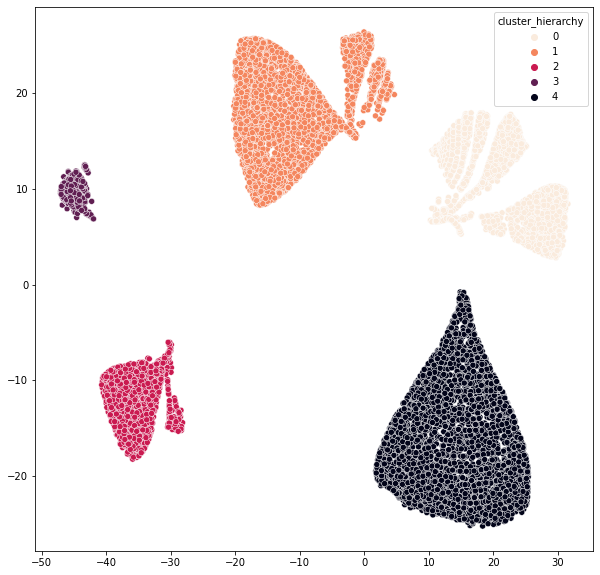

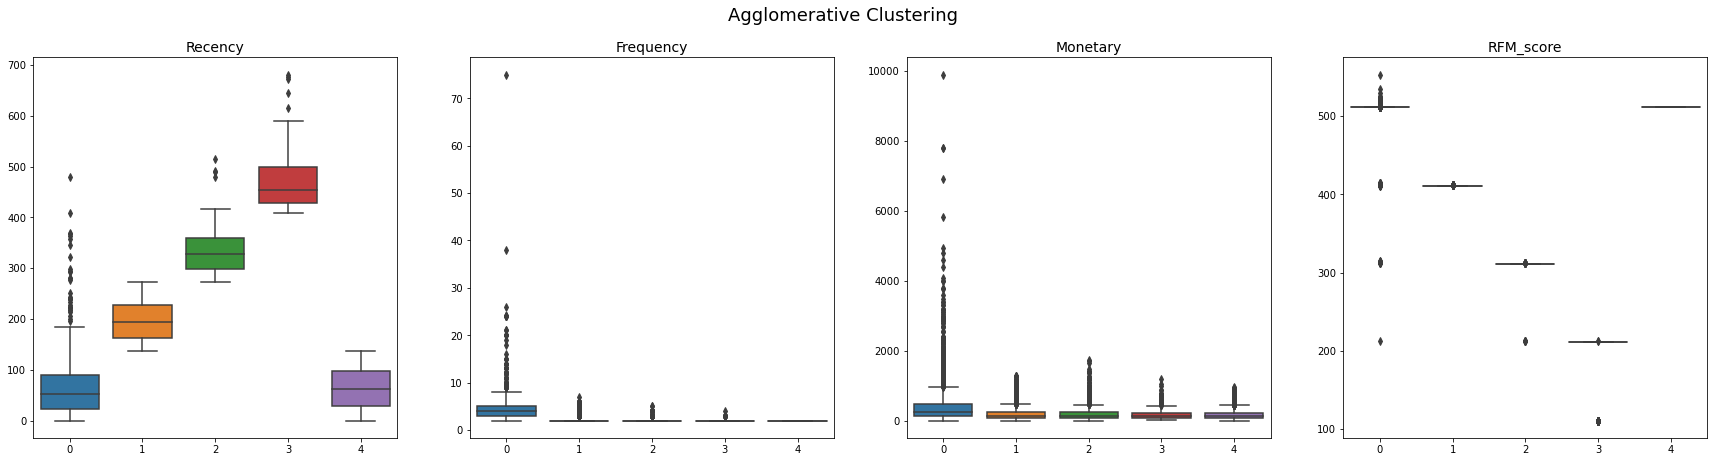

In [6]:
# RFM table for the whole dataset.
rfm_mod1 = RFM_Clustering(df, ndays=total_days)
rfm01 = rfm_mod1.RFM()

# Creating X for clustering.
X = rfm01.loc[:, ["Recency", "Frequency", "Monetary", "RFM_score"]]
rfm01 = rfm_mod1.Clustering(X, x_pos=5.0, ymax=150, p=2, perplexity=500)

Le cluster des meilleurs clients est ici est le __Cluster $0$__.

Silhouette Score = 0.6611876487731934
Calinski Harabasz Score =29596.758766448547


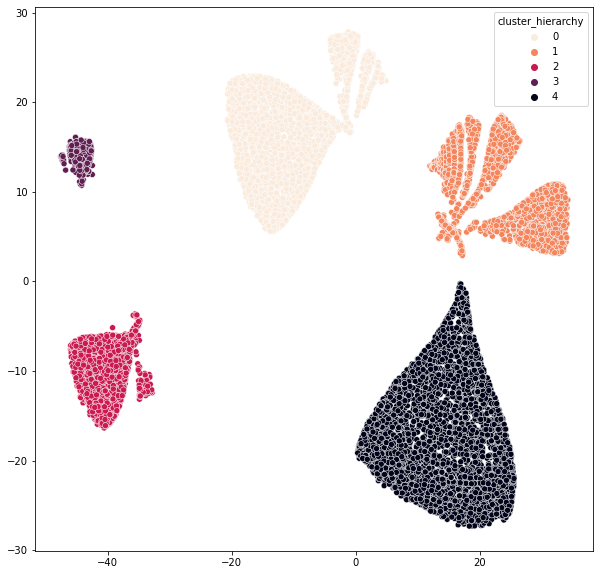

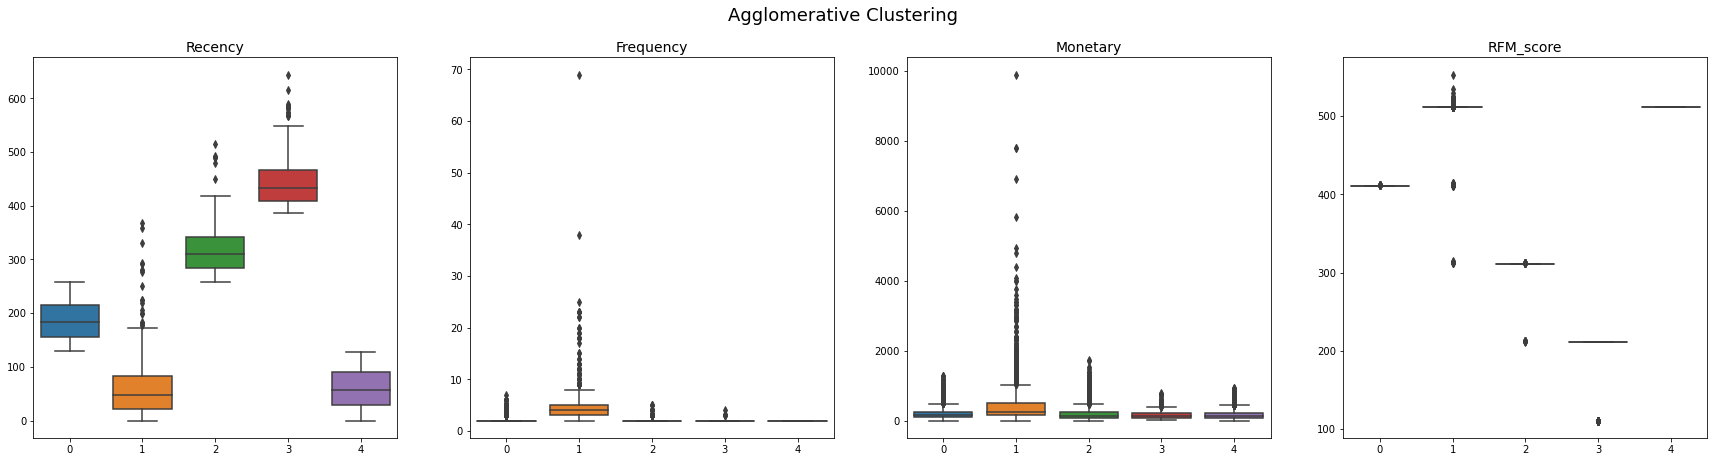

In [7]:
# Creating the RFM table 3 months earlier (a months is taken to have 30 daysw)
rfm_mod2 = RFM_Clustering(df, ndays=total_days - (30 * 3))
rfm02 = rfm_mod2.RFM()

# Creating X for clustering.
X = rfm02.loc[:, ["Recency", "Frequency", "Monetary", "RFM_score"]]
rfm02 = rfm_mod2.Clustering(X, x_pos=5.0, ymax=150, p=2, perplexity=400)

Le cluster des meilleurs clients est ici est le __Cluster $1$__.

Silhouette Score = 0.6604946851730347
Calinski Harabasz Score =24252.91355977393


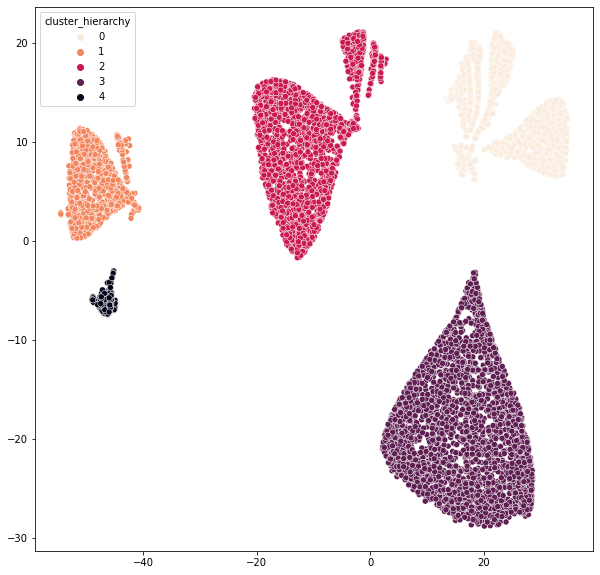

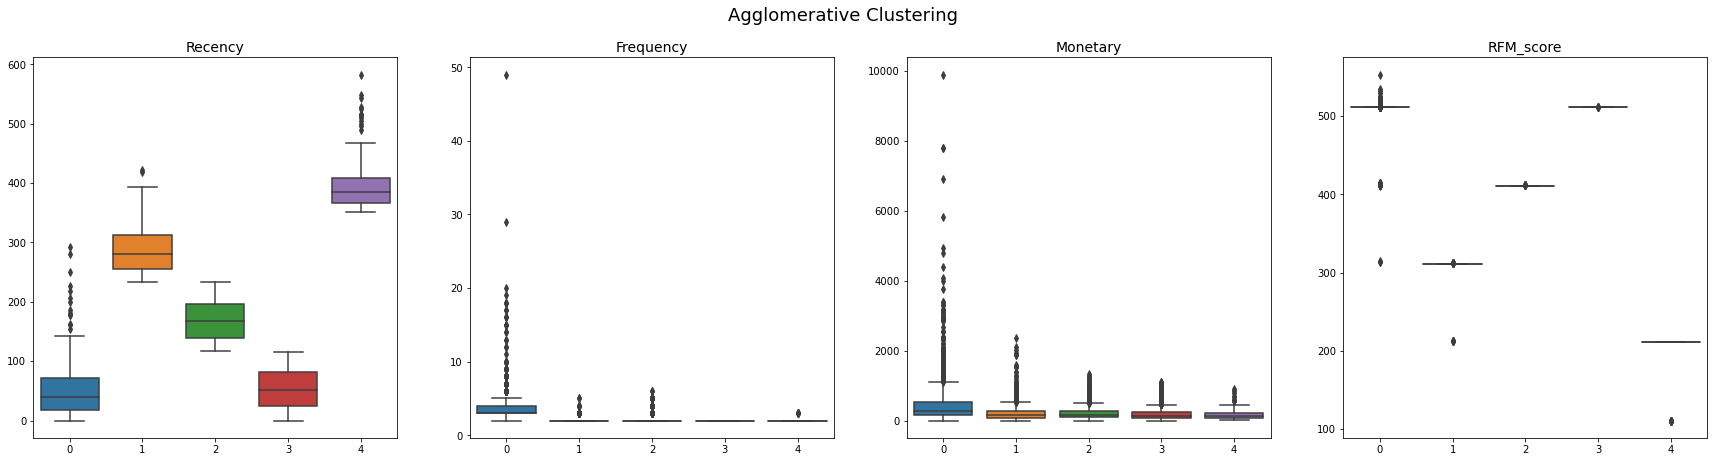

In [8]:
# Creating the RFM table 6 months earlier
rfm_mod3 = RFM_Clustering(df, ndays=total_days - (30 * 6))
rfm03 = rfm_mod3.RFM()

# Creating X for clustering.
X = rfm03.loc[:, ["Recency", "Frequency", "Monetary", "RFM_score"]]
rfm03 = rfm_mod3.Clustering(X, x_pos=5.0, ymax=150, p=2, perplexity=300)

Le cluster des meilleurs clients est ici est le __Cluster $0$__.

Silhouette Score = 0.6739095449447632
Calinski Harabasz Score =16587.117792095774


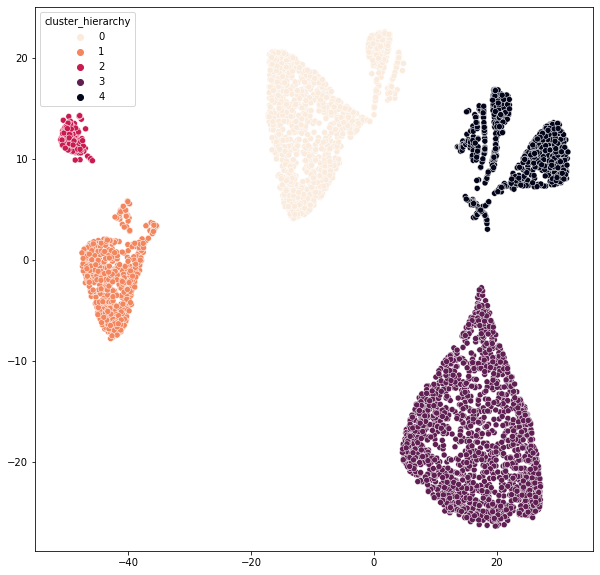

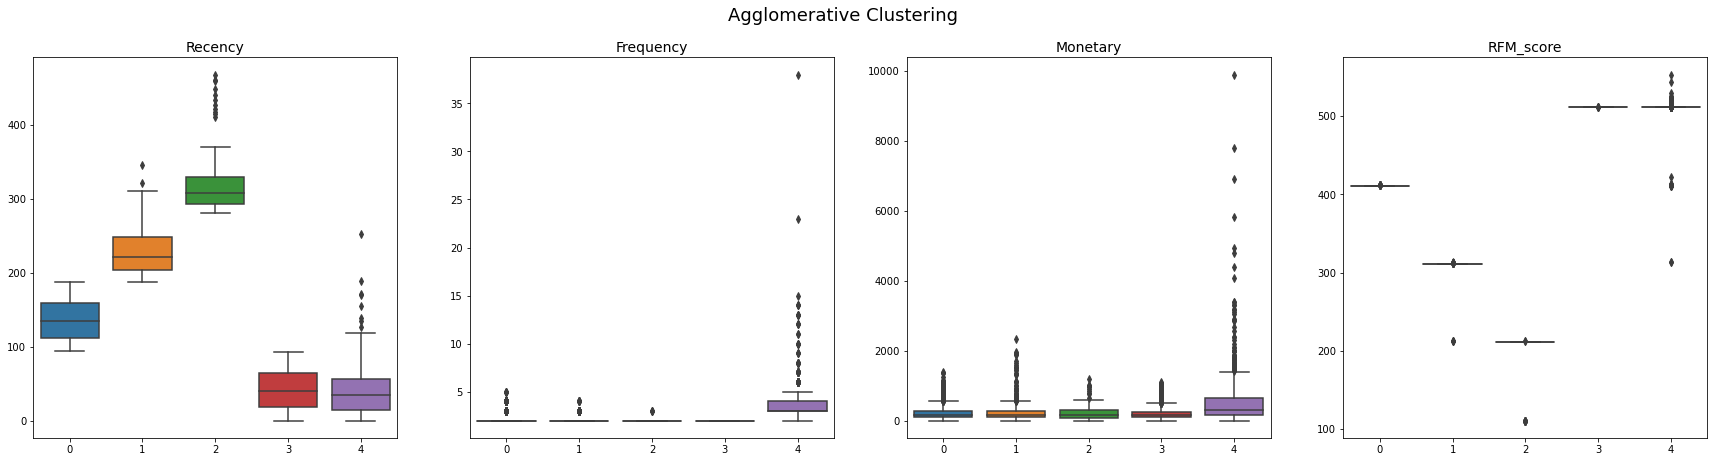

In [9]:
# Creating the RFM table 9 months earlier
rfm_mod4 = RFM_Clustering(df, ndays=total_days - (30 * 9))
rfm04 = rfm_mod4.RFM()

# Creating X for clustering.
X = rfm04.loc[:, ["Recency", "Frequency", "Monetary", "RFM_score"]]
rfm04 = rfm_mod4.Clustering(X, x_pos=5.0, ymax=150, p=2, perplexity=200)

Le cluster des meilleurs clients est ici est le __Cluster $4$__.

Silhouette Score = 0.5558190941810608
Calinski Harabasz Score =2198.7850375742782


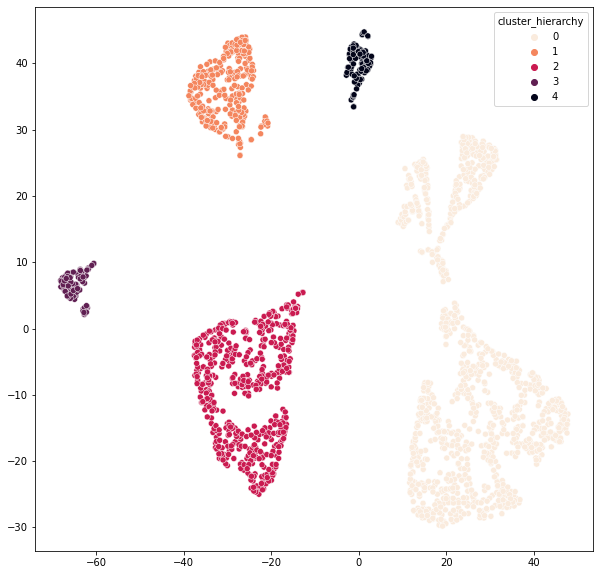

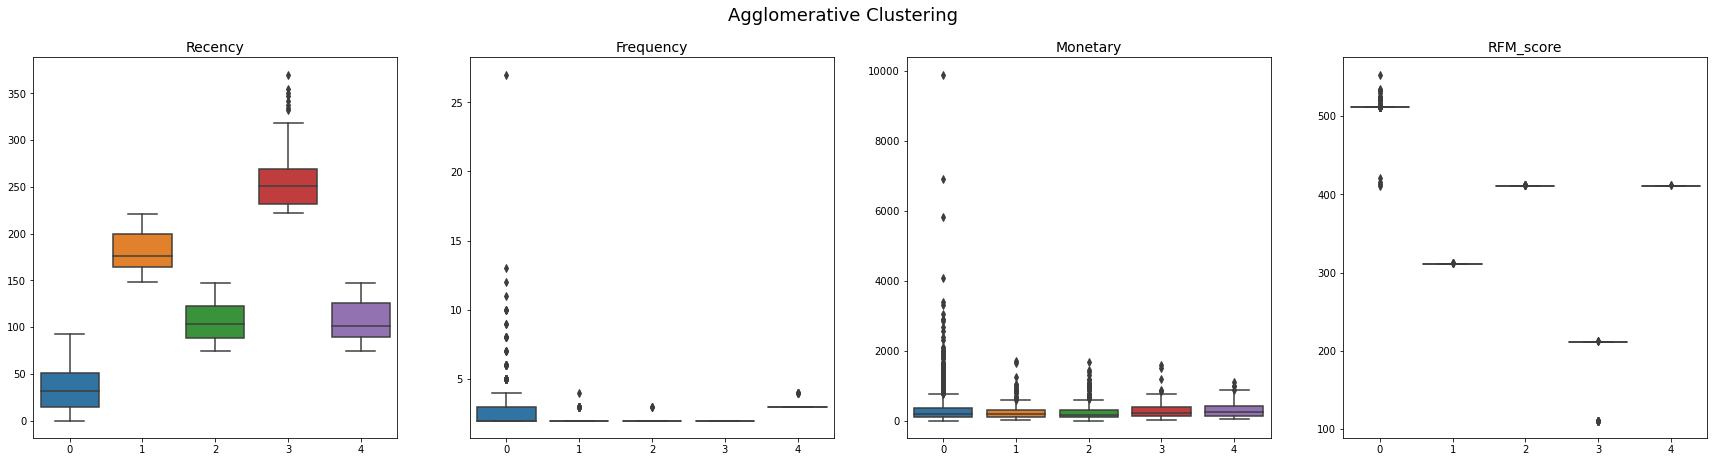

In [10]:
# Creating the RFM table 12 months earlier
rfm_mod5 = RFM_Clustering(df, ndays=total_days - (30 * 12))
rfm05 = rfm_mod5.RFM()

# Creating X for clustering.
X = rfm05.loc[:, ["Recency", "Frequency", "Monetary", "RFM_score"]]
rfm05 = rfm_mod5.Clustering(X, x_pos=5.0, ymax=150, p=2, perplexity=50)

Le cluster des meilleurs clients est ici est le __Cluster $0$__.

Silhouette Score = 0.5390937924385071
Calinski Harabasz Score =1738.2716449806976


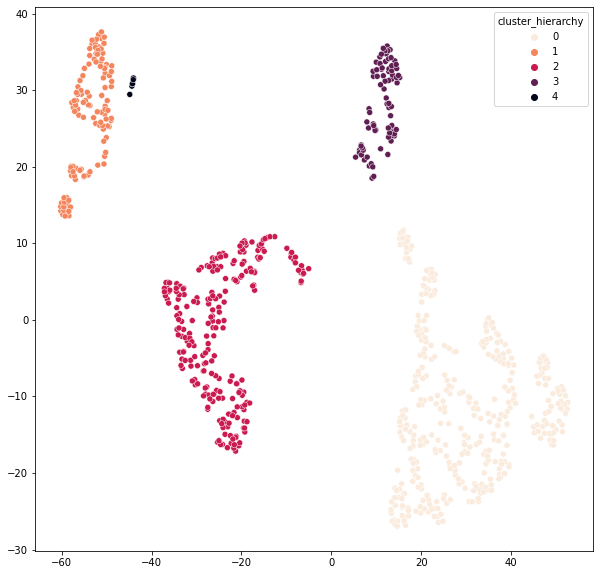

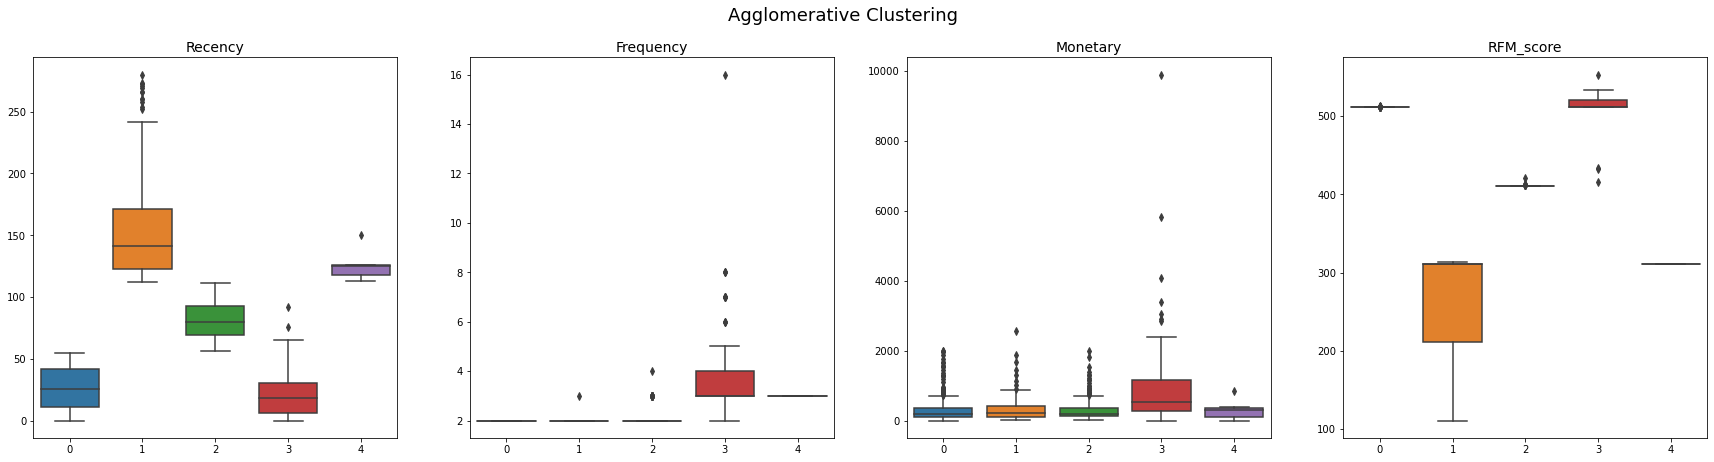

In [11]:
# Creating the RFM table 15 months earlier
rfm_mod6 = RFM_Clustering(df, ndays=total_days - (30 * 15))
rfm06 = rfm_mod6.RFM()

# Creating X for clustering.
X = rfm06.loc[:, ["Recency", "Frequency", "Monetary", "RFM_score"]]
rfm06 = rfm_mod6.Clustering(X, x_pos=5.0, ymax=150, p=2, perplexity=25)

Le cluster des meilleurs clients est ici est le __Cluster $3$__.

# Analyse des résultats


In [12]:
WholePeriod = rfm01.loc[rfm01.cluster_hierarchy == 0, :].reset_index(drop=True)
_3MonthsEarlier = rfm02.loc[rfm02.cluster_hierarchy == 1, :].reset_index(drop=True)
print(WholePeriod.shape)
print(_3MonthsEarlier.shape)

(2417, 10)
(2084, 10)


In [13]:
ChangeIn3Months = pd.merge(
    WholePeriod, _3MonthsEarlier, on="customer_unique_id", how="left"
).loc[:, ["customer_unique_id", "cluster_hierarchy_x", "cluster_hierarchy_y"]]
DifferenceAter3Months = (
    ChangeIn3Months.cluster_hierarchy_x.count()
    - ChangeIn3Months.cluster_hierarchy_y.count()
)
DifferenceAter3Months

433

In [14]:
List_of_RFM = [rfm02, rfm03, rfm04, rfm05, rfm06]
List_of_same_cluster = [1, 0, 4, 0, 3]
Differences_list = []

for i, (rfm, clusterNumber) in enumerate(zip(List_of_RFM, List_of_same_cluster)):
    WholePeriod = rfm01.loc[rfm01.cluster_hierarchy == 0, :].reset_index(drop=True)
    _3MonthsEarlier = rfm.loc[rfm.cluster_hierarchy == clusterNumber, :].reset_index(
        drop=True
    )

    ChangeIn3Months = pd.merge(
        WholePeriod, _3MonthsEarlier, on="customer_unique_id", how="left"
    ).loc[:, ["customer_unique_id", "cluster_hierarchy_x", "cluster_hierarchy_y"]]
    Diff = abs(
        ChangeIn3Months.cluster_hierarchy_x.count()
        - ChangeIn3Months.cluster_hierarchy_y.count()
    )
    Differences_list.append(
        [
            3 + i * 3,
            ChangeIn3Months.cluster_hierarchy_x.count(),
            ChangeIn3Months.cluster_hierarchy_y.count(),
            Diff,
        ]
    )

In [15]:
differences_frame = pd.DataFrame(
    Differences_list,
    columns=["months_earlier", "total_num_customer", "num_customer", "difference"],
)
differences_frame["cumsum_diff"] = differences_frame.difference.cumsum()
differences_frame["percentage_change"] = (
    differences_frame.difference / differences_frame.total_num_customer
) * 100
differences_frame

,months_earlier,total_num_customer,num_customer,difference,cumsum_diff,percentage_change
0,3,2417,1984,433,433,17.914770
1,6,2417,1245,1172,1605,48.489863
2,9,2417,600,1817,3422,75.175838
3,12,2417,402,2015,5437,83.367811
4,15,2417,62,2355,7792,97.434837


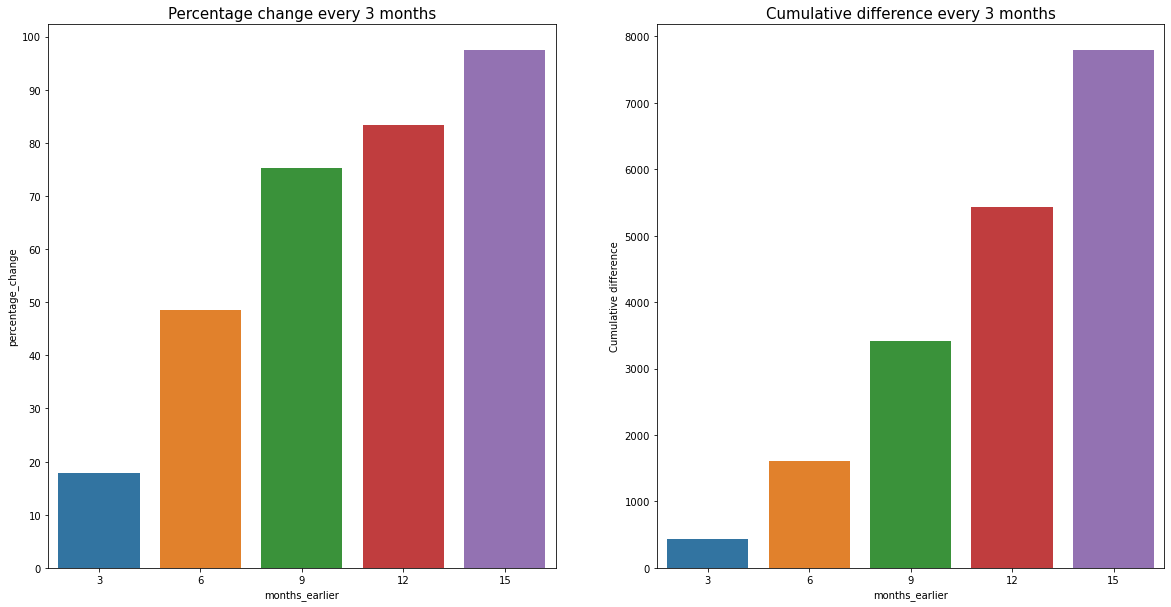

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_title("Percentage change every 3 months", fontsize=15)
sns.barplot(data=differences_frame, x="months_earlier", y="percentage_change", ax=ax[0])
ax[0].set_yticks(np.arange(0, 101, 10))

ax[1].set_title("Cumulative difference every 3 months", fontsize=15)
sns.barplot(data=differences_frame, x="months_earlier", y="cumsum_diff", ax=ax[1])
ax[1].set_ylabel("Cumulative difference")
plt.savefig(path + "Stability.png", bbox_inches="tight", facecolor="w")

plt.show()

# Conclusion sur le temps de maintenance


> En étudiant les clients d'un cluster, celui qui contient les clients les plus récents, fréquents et qui ont tendance à dépenser plus, nous observant que trois mois auparavant, 433 clients n'était pas dans ce clusters. Cela corresponds à une différence de $18$%. Et lorsqu'on remonte à six mois plus tôt, environ $50$% des clients du clusters sont absents. 

> Nous en concluons que la fréquence de mise-à-jour doit être de 6 mois, le temps pendant lequel nous avons environ $50$% de changement dans le cluster des meilleurs clients.